# Denoising Images using an Autoencoder 

In [27]:
import numpy as np
import tensorflow as tf
#from tensorflow import keras
#from keras import layers as tfl
import os, random
from PIL import Image
#from keras.utils import image_dataset_from_directory
import matplotlib.pyplot as plt
from skimage.util import random_noise

ImportError: dlopen(/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tensorflow/python/_pywrap_tfe.so, 0x0002): Symbol not found: __Z19TFE_Py_TapeGradientP7_objectS0_S0_S0_S0_S0_P10TSL_Status
  Referenced from: <9F7A8911-0201-390E-B874-276C524E7865> /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tensorflow/python/_pywrap_tfe.so
  Expected in:     <FC7732B8-90D5-37E4-8971-6411BDF2B8F5> /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tensorflow/python/_pywrap_tensorflow_internal.so

## Pre-processing

In [8]:
CelebAImagesPath = 'archive/img_align_celeba/img_align_celeba/'
CelebANoisyPath = 'archive/img_align_celeba/img_noisy_celeba/'

Exploring the images:

In [17]:
def plot_images(path):
    W_grid = 4
    L_grid = 2
    fig, axes = plt.subplots(L_grid, W_grid, figsize = (16,8))
    axes = axes.ravel() #flaten into array

    for i in np.arange(0, W_grid * L_grid):
        img = random.choice(os.listdir(path))
        axes[i].imshow(Image.open(os.path.join(path,img)))
        axes[i].axis('off')

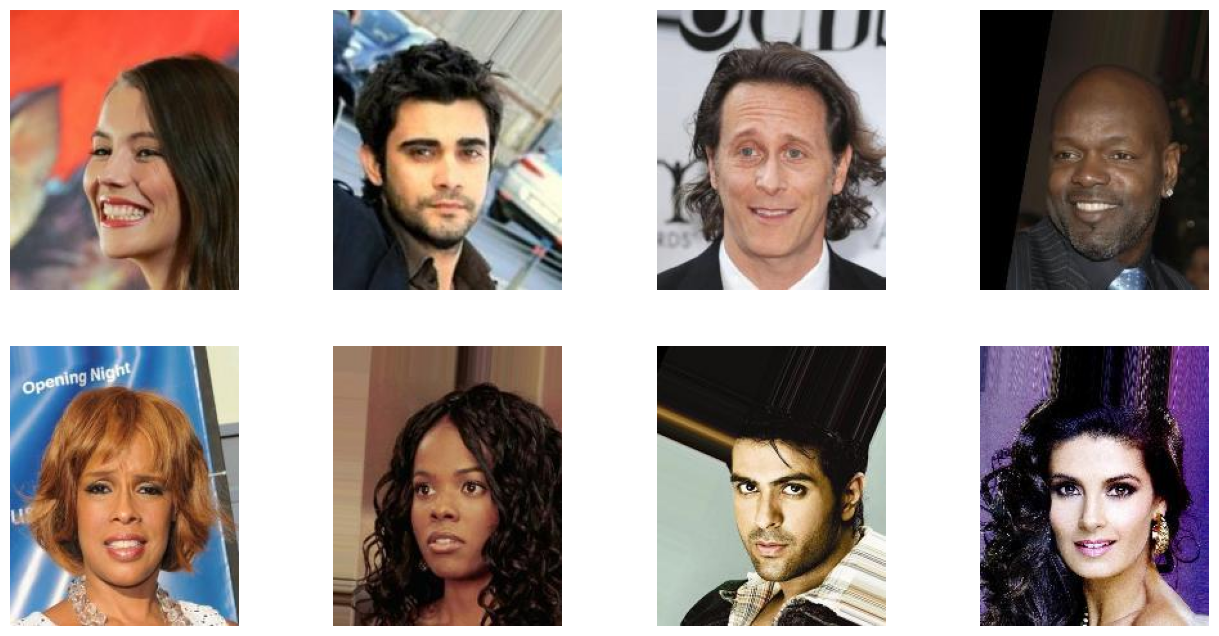

In [18]:
plot_images(CelebAImagesPath)

Checking image sizes:

In [7]:
width, height = Image.open(os.path.join(CelebAImagesPath,'000001.jpg')).size
x = True

for img in os.listdir(CelebAImagesPath):
    w, h = Image.open(os.path.join(CelebAImagesPath,img)).size
    if w != width or h != height:
        print("Images are not all the same size!")
        x = False
        break
if x == True:
    print("Images are all of size:\nWidth: %d\nHeight: %d"%(width,height))

Images are all of size:
Width: 178
Height: 218


Adding noise:

In [15]:
def add_noise(img, dest):
    im = np.asarray(img)
    imnoise = random_noise(im)
    noisy = Image.fromarray((imnoise*255).astype(np.uint8))
    noisy.save(dest)   

for file in os.listdir(CelebAImagesPath):
    img = Image.open(os.path.join(CelebAImagesPath,file))
    dest = os.path.join(CelebANoisyPath,file)
    add_noise(img,dest)

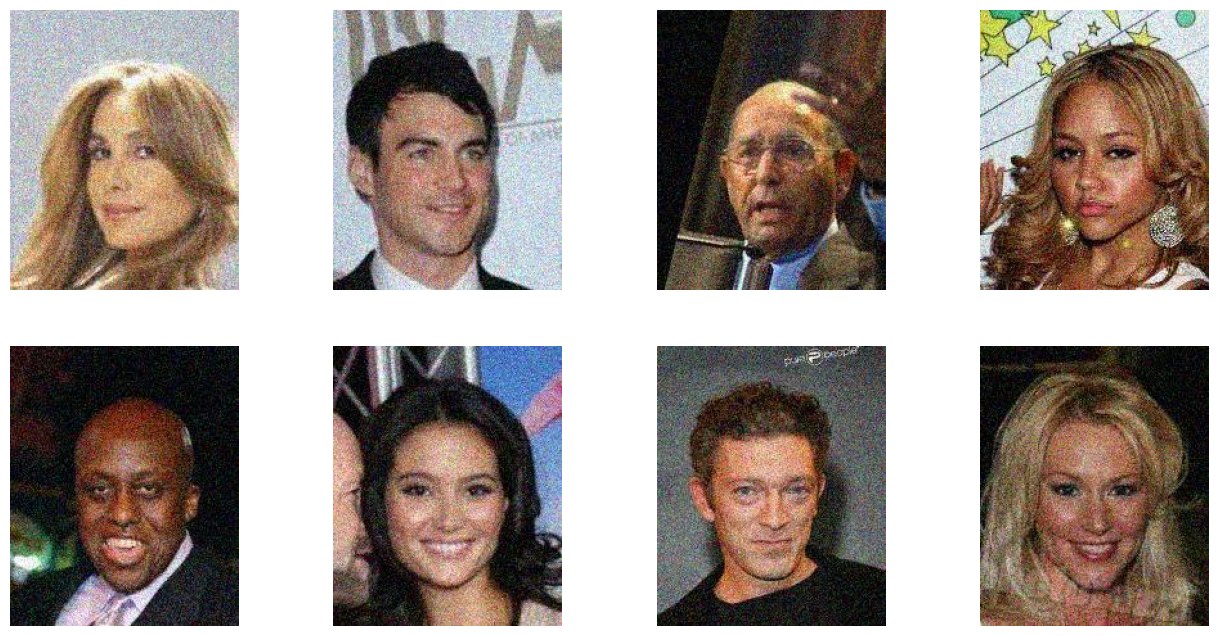

In [19]:
plot_images(CelebANoisyPath)

Forming the train and test sets:

In [12]:
IMG_SIZE = (height,width) 
BATCH_SIZE = None
directory = CelebAImagesPath
train_dataset = image_dataset_from_directory(directory,
                                             label_mode=None,
                                             image_size=IMG_SIZE,
                                             #batch_size=BATCH_SIZE,
                                             validation_split=0.4,
                                             subset='training',
                                             seed=42)
validation_dataset = image_dataset_from_directory(directory,
                                                  label_mode=None,
                                                  image_size=IMG_SIZE,
                                                  #batch_size=BATCH_SIZE,
                                                  validation_split=0.4,
                                                  subset='validation',
                                                  seed=42)

Found 202599 files belonging to 1 classes.
Using 121560 files for training.
Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2023-04-12 19:05:25.636941: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-04-12 19:05:25.638746: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Found 202599 files belonging to 1 classes.
Using 81039 files for validation.


In [ ]:
directory = CelebAImagesPath
noisy_train_dataset = image_dataset_from_directory(directory,
                                             label_mode=None,
                                             image_size=IMG_SIZE,
                                             #batch_size=BATCH_SIZE,
                                             validation_split=0.4,
                                             subset='training',
                                             seed=42)
noisy_validation_dataset = image_dataset_from_directory(directory,
                                                  label_mode=None,
                                                  image_size=IMG_SIZE,
                                                  #batch_size=BATCH_SIZE,
                                                  validation_split=0.4,
                                                  subset='validation',
                                                  seed=42)

Normalizing the data:

In [30]:
train_dataset = train_dataset.astype(float) / 255.0
validation_dataset = validation_dataset.astype(float) / 255.0

AttributeError: 'BatchDataset' object has no attribute 'astype'

## Building the AE for Denoising

In [ ]:
autoencoder = tf.keras.models.Sequential()
# encoder
autoencoder.add(tf.keras.layers.Conv2D(filters = 16, kernel_size = 3, strides = 2, padding = 'same', input_shape = (28, 28, 1)))
autoencoder.add(tf.keras.layers.Conv2D(filters = 8, kernel_size = 3, strides = 2, padding = 'same'))
#bottleneck coding : (7, 7, 8)
autoencoder.add(tf.keras.layers.Conv2D(filters = 8, kernel_size = 3, strides = 1, padding = 'same'))
# decoder
autoencoder.add(tf.keras.layers.Conv2DTranspose(filters = 16, kernel_size = 3, strides = 2, padding = 'same'))
autoencoder.add(tf.keras.layers.Conv2DTranspose(filters = 1, kernel_size = 3, strides = 2, activation = 'sigmoid', padding = 'same'))


autoencoder.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=0.001))
autoencoder.summary()

autoencoder.fit(noise_train.reshape(-1, 28, 28, 1),
               X_train.reshape(-1, 28, 28, 1),
               epochs = 10,
               batch_size = 200,
               validation_data = (noise_test.reshape(-1, 28, 28, 1), X_test.reshape(-1, 28, 28, 1)))

In [ ]:
input = tfl.Input(shape=(28, 28, 1))

# Encoder
x = tfl.Conv2D(32, (3, 3), activation="relu", padding="same")(input)
x = tfl.MaxPooling2D((2, 2), padding="same")(x)
x = tfl.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = tfl.MaxPooling2D((2, 2), padding="same")(x)

# Decoder
x = tfl.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = tfl.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = tfl.Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)

# Autoencoder
autoencoder = Model(input, x)
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")
autoencoder.summary()

autoencoder.fit(
    x=train_data,
    y=train_data,
    epochs=50,
    batch_size=128,
    shuffle=True,
    validation_data=(test_data, test_data),
)

## Evaluating